PLEASE NOTE: THE INTERACTIVE FOLIUM MAPS WILL NOT RENDER WHEN THE NOTEBOOK IS SIMPLY DISPLAYED USING THE PROVIDED GITHUB LINK; TO VIEW THE NOTEBOOK WITH THE RENDERED MAP PLEASE PASTE THE PROVIDED LINK INTO NBVIEWER. <https://nbviewer.jupyter.org/>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Indian restaurant** in **Manhattan**, New York.

Since there are lots of restaurants in Manhattan we will try to detect **neighborhoods with no Indian restaurants in vicinity**. We would also prefer locations **as close to city center as possible** at the same time **rent for the restaurant needs to be affordable**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of Indian restaurants in the neighborhood.
* average rent in the neighborhood.
* distance of neighborhood from cultural center of Manhattan i.e Empire State Building.

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Manhattan, neighborhood will be obtained using **Google Maps API geocoding** 

### Download all the dependencies that we will need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

'conda' is not recognized as an internal or external command,
operable program or batch file.


Libraries imported.


### Download and Explore Dataset

New York has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood in Manhattan.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
import json

with open("C:/Users/DeLL/Desktop/Capstone/'newyork_data.json'") as f:
  newyork_data = json.load(f)

newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

* The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.
* Then let's loop through the data and fill the dataframe one row at a time.

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Lets the dataset has all 5 boroughs and 306 neighborhoods.

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Since we're only concerned with the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [9]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


Lets find the geograpical coordinate of Manhattan.

In [10]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [11]:
pip install pyproj

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\dell\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


To accurately calculate distances we need to create a Cartesian 2D coordinate system for all neighborhoods in Manhattan which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [12]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    print(xy)
    return xy[0], xy[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

We found the geographical coordinates for Empire State Building (an important landmark in Manhattan). This can be considered the cultural center of the Borough. I found the coordinates here <https://www.gps-latitude-longitude.com/gps-coordinates-of-empire-state-building-new-york>

In [42]:
manhattan_latitude=40.748441
manhattan_longitude=-73.985664
x1, y1 = lonlat_to_xy(manhattan_longitude, manhattan_latitude)
print('Manhattan center UTM X={}, Y={}'.format(x1, y1))

(-5816164.040603542, 9867141.149619138)
Manhattan center UTM X=-5816164.040603542, Y=9867141.149619138


<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)


Lets find the UTM Cartesian coordinates for all neighborhoods in Manhattan and put it into a dataframe.

In [14]:
UTM=[]
neighborhood_UTM=[]

for lng,lat in zip(manhattan_data['Longitude'],manhattan_data['Latitude']):
    UTM=lonlat_to_xy(lng,lat)
    neighborhood_longitude=UTM[0]
    neighborhood_latitude=UTM[1]
    
    neighborhood_UTM.append((neighborhood_longitude,neighborhood_latitude))
    
manhattan_UTM=pd.DataFrame(neighborhood_UTM)
manhattan_UTM.columns = ["Longitude_UTM", "Latitude_UTM"]

(-5794205.022193088, 9858099.341502635)
(-5821759.992408587, 9868102.920270251)
(-5798469.917918929, 9861349.450659674)
(-5795743.343531575, 9859410.495268444)
(-5803304.601442826, 9862858.506499602)
(-5804461.181676784, 9863816.996826004)
(-5804572.580078747, 9861989.45390954)
(-5808593.717286384, 9862001.623600012)
(-5811466.1411834685, 9864025.325845836)
(-5811368.816213344, 9862302.120292732)
(-5812735.468989145, 9863777.766019836)
(-5813709.550086599, 9862500.926806986)
(-5809488.364088896, 9866212.566963926)
(-5811910.942092704, 9867213.841059556)
(-5814393.282311799, 9868537.378203196)
(-5815090.636027928, 9866654.77135156)
(-5816161.820734775, 9866195.243801693)
(-5816971.261459896, 9869371.41588882)
(-5819860.265049993, 9868881.306989977)
(-5819643.990365061, 9866603.353600796)
(-5821342.207405835, 9866384.812001176)
(-5820814.802131475, 9870246.650360726)
(-5821141.885515797, 9868510.190404436)
(-5820668.289895135, 9868955.700964434)
(-5818609.626628879, 9869723.419039968)
(-

<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-12-7c5f77b235b3>:12: DeprecationWarning: This

In [15]:
manhattan_UTM.head()

,Longitude_UTM,Latitude_UTM
0,-5.794205e+06,9.858099e+06
1,-5.821760e+06,9.868103e+06
2,-5.798470e+06,9.861349e+06
3,-5.795743e+06,9.859410e+06
4,-5.803305e+06,9.862859e+06


We have the UTM Cartesian coordinates for Manhattan centre. Now lets find the distance of each neighborhood from the borough centre and put it into a dataframe.

In [44]:
x1=9867141.149619138 #latitude of Manhattan Centre (Empire State Building)
y1=-5816164.040603542 #Longitude of Manhattan Centre (Empire State Building)

Centre_0=[]
Centre_1=[]

for lat,lng in zip(manhattan_UTM['Latitude_UTM'],manhattan_UTM['Longitude_UTM']):
    Centre_0=calc_xy_distance(x1, y1, lat, lng)
    
    Centre_1.append(Centre_0)
    
manhattan_dist=pd.DataFrame(Centre_1)
manhattan_dist.columns = ["Distance_from_centre"]
manhattan_dist.head()

,Distance_from_centre
0,23747.690068
1,5677.999594
2,18617.888022
3,21835.015127
4,13553.826309


In [101]:
manhattan_combined=manhattan_data.join(manhattan_dist)
manhattan_combined=manhattan_combined.drop(['Borough'], axis = 1) #we don't need the borough column.
manhattan_combined.head()

,Neighborhood,Latitude,Longitude,Distance_from_centre
0,Marble Hill,40.876551,-73.910660,23747.690068
1,Chinatown,40.715618,-73.994279,5677.999594
2,Washington Heights,40.851903,-73.936900,18617.888022
3,Inwood,40.867684,-73.921210,21835.015127
4,Hamilton Heights,40.823604,-73.949688,13553.826309


Lets use Folium to visualize all the neighborhoods in Manhattan.

In [184]:
latitude=40.7896239 #latitude of Manhattan 
longitude=-73.95989392 #Longitude of Manhattan 
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(manhattan_combined['Latitude'], manhattan_combined['Longitude'], manhattan_combined['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Foursquare
Now that we have our location information for all neighborhoods in Manhattan. Let's use Foursquare API to get info on Indian restaurants in each neighborhood.

We're interested in only **Indian Restaurants**. We'll be cleaning the results to remove everything else. 

In [19]:
CLIENT_ID = 'MBME5IYZ3TOV1HV505GJLTYNYNDPG2S3YKLJIWUFAY1V1WP2' # your Foursquare ID
CLIENT_SECRET = 'IAPXG331OD0ER5IW3JCDT5E3DVYCEXBPXRWBLPHICXHNVSNL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MBME5IYZ3TOV1HV505GJLTYNYNDPG2S3YKLJIWUFAY1V1WP2
CLIENT_SECRET:IAPXG331OD0ER5IW3JCDT5E3DVYCEXBPXRWBLPHICXHNVSNL


In [20]:
def getIndianRestaurants(names, latitudes, longitudes, radius=500):
    
    search_query = 'Indian'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)

            
        # make the GET request
        results = requests.get(url).json()['response']
        
        venue_result=[]     
        
        for v in results['venues']:
            venue_name=v['name']
            venue_latitude=v['location']['lat']
            venue_longitude=v['location']['lng']

            if v['categories']:
                venue_category=v['categories'][0]['name']

            else:
                venue_category="NA" 
        
            venue_result.append((name,lat,lng,venue_name,venue_latitude,venue_longitude,venue_category))
            
        venues_list.append(venue_result)
                

    indian_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    indian_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(indian_venues)

In [49]:
#Lets go through our neighborhood locations to find all Indian venues.

LIMIT=100
radius=500

manhattan_venues = getIndianRestaurants(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

condition=manhattan_venues['Venue Category']=='Indian Restaurant'#drop all other venues
manhattan_venues=manhattan_venues[condition].reset_index(drop=True)
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Riverdale Indian Cuisine,40.880886,-73.908800,Indian Restaurant
1,Chinatown,40.715618,-73.994279,Indian Restaurant,40.719978,-73.995903,Indian Restaurant
2,Chinatown,40.715618,-73.994279,Curry House Indian Cuisine,40.719864,-73.990425,Indian Restaurant
3,Washington Heights,40.851903,-73.936900,Kismat Indian Restaurant,40.855222,-73.936967,Indian Restaurant
4,Washington Heights,40.851903,-73.936900,indian valley,40.847304,-73.936657,Indian Restaurant


#### Average Rent in Manhattan (Rental Market Trends)

An important part of the study is to also look at affordability. For this purpose I found a dataset with average rents for Manhattan here <https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/>. Lets import this and merge it with our existing dataframe for clustering purposes.

In [53]:
manhattan_rent=pd.read_excel("C:/Users/DeLL/Desktop/Capstone/Datasets/Manhattan_Rent_1.xlsx") #I converted that data into an excel sheet

manhattan_rent.head()

,Neighborhood,AverageRent
0,Marble Hill,1708
1,Washington Heights,2284
2,Inwood,2375
3,Randalls and Wards Islands,2394
4,Manhattanville,2940


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting neighborhoods of Manhattan with low number of Indian restaurants. We will then look for the most affordable neighborhoods closest to the centre of Manhattan. 

In first step we have collected the required **data: distance of each neighborhood from the centre of Manhattan**.We have also **identified Indian restaurants** (using Foursquare API). In order to understand the affordable neighborhoods we found the Rental Market Trends data. 

Second step in our analysis will be calculation '**restaurant density**' across different neighborhoods of Manhattan - we will use **heatmaps** to identify a few promising areas close to center with low number of Indian Restaurants and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **lesser than 2 Indian Restaurants**, and we want locations **most affordable rent**, and **closest to the cultural centre of Manhattan**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify neighborhoods which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of Indian Restaurants in every neighborhood**:

In [35]:
manhattan_grouped=manhattan_venues[['Neighborhood','Venue']] #drop all other columns

manhattan_grouped=manhattan_grouped['Neighborhood'].value_counts().to_frame() #count the number of restaurants in each neighborhood

manhattan_grouped.reset_index(inplace=True)

manhattan_grouped = manhattan_grouped.rename(columns={'index': 'Neighborhood', 'Neighborhood': 'no_of_venues'}) #rename columns

manhattan_grouped.head()

,Neighborhood,no_of_venues
0,Noho,11
1,Midtown,10
2,Sutton Place,9
3,East Village,8
4,Greenwich Village,6


This dataframe only includes the neighborhoods with atleast one venue. There are other neighborhoods with **0 Indian Restaurants** which are extremely important to the study. Lets create a complete dataframe with all neighborhoods.

In [195]:
manhattan_all=manhattan_data.join(manhattan_grouped.set_index('Neighborhood'), on='Neighborhood') 

manhattan_all.fillna(0, inplace=True)#replace NaN with "0"

manhattan_all=manhattan_all.drop(['Borough'], axis = 1) #we don't need the borough column.

manhattan_all.head()

,Neighborhood,Latitude,Longitude,no_of_venues
0,Marble Hill,40.876551,-73.910660,1.0
1,Chinatown,40.715618,-73.994279,2.0
2,Washington Heights,40.851903,-73.936900,2.0
3,Inwood,40.867684,-73.921210,0.0
4,Hamilton Heights,40.823604,-73.949688,1.0


Let's crete a map showing **heatmap / density of Indian Restaurants** and try to extract some meaningfull info from that. Also, let's show a few circles indicating distance of 1km, 2km, 3km and 4km from Centre of Manhattan.

In [38]:
latitude=40.7896239 #latitude of Manhattan Centre
longitude=-73.95989392 #Longitude of Manhattan Centre
def generateBaseMap(default_location=[latitude, longitude], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map=generateBaseMap()
base_map

In [211]:
from folium.plugins import HeatMap
df_heatmap = manhattan_all.copy()
base_map = generateBaseMap()
manhattan_center=(40.748441, -73.985664)

df_heatmap['Latitude'] = df_heatmap['Latitude'].astype(float)
df_heatmap['Longitude'] = df_heatmap['Longitude'].astype(float)
df_heatmap = df_heatmap[['Latitude', 'Longitude']]

heat_data = [[row['Latitude'],row['Longitude']] for index, row in df_heatmap.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(base_map)
folium.Marker(manhattan_center).add_to(base_map)
folium.Circle(manhattan_center, radius=1000, fill=False, color='white').add_to(base_map)
folium.Circle(manhattan_center, radius=2000, fill=False, color='white').add_to(base_map)
folium.Circle(manhattan_center, radius=3000, fill=False, color='white').add_to(base_map)
folium.Circle(manhattan_center, radius=4000, fill=False, color='white').add_to(base_map)

for lat, lng, neighborhood in zip(manhattan_combined['Latitude'], manhattan_combined['Longitude'], manhattan_combined['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map)  
    
# Display the map
base_map

This heatmap gives us a broader idea of the density of the distribution of Indian Restaurants in the neighborhood. Particularly neighborhoods such as **Clinton, Flatiron, Lincoln Square, Chelsea, West Village, Hudson Yards, Stuyvesant Town** look promising.

But in order to get a better understanding of our ideal locations we need to filter out the neighborhoods with more than **2 Indian Restaurants**. After which we can bring in our **Rent Analysis Data** and proceed with the k-means clustering to find our ideal neighborhoods.

In [218]:
#filter out neighborhoods with more than 2 Indian Restaurants 

manhattan_low=manhattan_all[manhattan_all['no_of_venues']<=2.0].reset_index(drop=True)

manhattan_filtered=manhattan_low.join(manhattan_rent.set_index('Neighborhood'), on='Neighborhood') #join in the rental data

manhattan_filtered['AverageRent']=manhattan_filtered['AverageRent'].astype(float)

manhattan_filtered.head()

,Neighborhood,Latitude,Longitude,no_of_venues,AverageRent
0,Marble Hill,40.876551,-73.910660,1.0,1708.0
1,Chinatown,40.715618,-73.994279,2.0,5116.0
2,Washington Heights,40.851903,-73.936900,2.0,2284.0
3,Inwood,40.867684,-73.921210,0.0,2375.0
4,Hamilton Heights,40.823604,-73.949688,1.0,1995.0


We need to normalize the values in in no_of_venues and Average Rent.

In [219]:
manhattan_mid=manhattan_filtered.copy()

import pandas as pd
from sklearn import preprocessing

cols_to_norm = ['no_of_venues','AverageRent']

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
manhattan_mid[cols_to_norm] = min_max_scaler.fit_transform(manhattan_mid[cols_to_norm])

# Run the normalizer on the dataframe
manhattan_normalized = pd.DataFrame(manhattan_mid[cols_to_norm])

In [220]:
manhattan_normalized.head()

,no_of_venues,AverageRent
0,0.5,0.000000
1,1.0,0.874070
2,1.0,0.147730
3,0.0,0.171070
4,0.5,0.073609


We need to find the **optimal value of k for k-means clustering**. We'l do this by using the elbow method. 

In [221]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
X=manhattan_normalized
 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

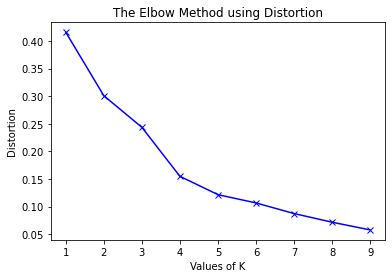

In [222]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

We can conclude that the optimal number of clusters for this data is **k = 4**

In [223]:
kclusters = 4


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

manhattan_filtered.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_filtered.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,no_of_venues,AverageRent
0,0,Marble Hill,40.876551,-73.910660,1.0,1708.0
1,2,Chinatown,40.715618,-73.994279,2.0,5116.0
2,0,Washington Heights,40.851903,-73.936900,2.0,2284.0
3,3,Inwood,40.867684,-73.921210,0.0,2375.0
4,0,Hamilton Heights,40.823604,-73.949688,1.0,1995.0


It is now clear that we need to be concerned with only **Cluster Label '0 & 1'**. 

Lets bring back the dataframe with the distance between the neighborhood and Empire State Building.

We will only retain neighborhoods in **Cluster Label '0 & 1' and those within a 4km radius** from the Empire State Building. 

In [224]:
manhattan_merged = pd.merge(manhattan_filtered, manhattan_combined, how='outer', on=['Neighborhood','Latitude','Longitude'])

manhattan_merged.dropna(inplace=True)

In [225]:
manhattan_merged

,Cluster Labels,Neighborhood,Latitude,Longitude,no_of_venues,AverageRent,Distance_from_centre
0,0.0,Marble Hill,40.876551,-73.910660,1.0,1708.0,23747.690068
1,2.0,Chinatown,40.715618,-73.994279,2.0,5116.0,5677.999594
2,0.0,Washington Heights,40.851903,-73.936900,2.0,2284.0,18617.888022
3,3.0,Inwood,40.867684,-73.921210,0.0,2375.0,21835.015127
4,0.0,Hamilton Heights,40.823604,-73.949688,1.0,1995.0,13553.826309
5,0.0,Manhattanville,40.816934,-73.957385,1.0,2940.0,12165.808598
6,0.0,Central Harlem,40.815976,-73.943211,1.0,2948.0,12684.712286
7,0.0,East Harlem,40.792249,-73.944182,2.0,2965.0,9150.110536
8,1.0,Upper East Side,40.775639,-73.960508,1.0,4676.0,5637.252589
9,2.0,Yorkville,40.775930,-73.947118,2.0,4458.0,6812.516552


In [226]:
# Lets keep only Cluster Labels '0 & 1'

manhattan_data=manhattan_merged[manhattan_merged['Cluster Labels']<2.0].reset_index(drop=True)
manhattan_data

,Cluster Labels,Neighborhood,Latitude,Longitude,no_of_venues,AverageRent,Distance_from_centre
0,0.0,Marble Hill,40.876551,-73.910660,1.0,1708.0,23747.690068
1,0.0,Washington Heights,40.851903,-73.936900,2.0,2284.0,18617.888022
2,0.0,Hamilton Heights,40.823604,-73.949688,1.0,1995.0,13553.826309
3,0.0,Manhattanville,40.816934,-73.957385,1.0,2940.0,12165.808598
4,0.0,Central Harlem,40.815976,-73.943211,1.0,2948.0,12684.712286
5,0.0,East Harlem,40.792249,-73.944182,2.0,2965.0,9150.110536
6,1.0,Upper East Side,40.775639,-73.960508,1.0,4676.0,5637.252589
7,0.0,Lower East Side,40.717807,-73.980890,1.0,3269.0,5233.111696
8,1.0,West Village,40.734434,-74.006180,1.0,4598.0,3556.544161
9,1.0,Morningside Heights,40.808000,-73.963896,1.0,4388.0,10476.710866


Lets only keep the neighborhoods **within a 4km radius from the Empire State Building.**

In [227]:
manhattan_ideal=manhattan_data[manhattan_data['Distance_from_centre']<4000.0].reset_index(drop=True)
manhattan_ideal

,Cluster Labels,Neighborhood,Latitude,Longitude,no_of_venues,AverageRent,Distance_from_centre
0,1.0,West Village,40.734434,-74.006180,1.0,4598.0,3556.544161
1,1.0,Tudor City,40.746917,-73.971219,1.0,3808.0,1880.851475
2,1.0,Hudson Yards,40.756658,-74.000111,1.0,4416.0,2326.484045


Lets use Folium to visualize these neighborhoods.

In [66]:
latitude=40.7896239 #latitude of Manhattan 
longitude=-73.95989392 #Longitude of Manhattan 
map_ideal_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(manhattan_ideal['Latitude'], manhattan_ideal['Longitude'], manhattan_ideal['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ideal_neighborhoods)
    folium.Circle(manhattan_center, radius=1000, fill=False, color='white').add_to(map_ideal_neighborhoods)
    folium.Circle(manhattan_center, radius=2000, fill=False, color='white').add_to(map_ideal_neighborhoods)
    folium.Circle(manhattan_center, radius=3000, fill=False, color='white').add_to(map_ideal_neighborhoods)
    folium.Circle(manhattan_center, radius=4000, fill=False, color='white').add_to(map_ideal_neighborhoods)
    
map_ideal_neighborhoods

As is clear from the analysis the client should consider **West Village,Tudor City,Hudson Yards** for opening his Indian Restaurant.

In [67]:
map_ideal_neighborhoods.save('map_ideal_neighborhoods.html')

## Results and Discussion <a name="results"></a>

Our analysis shows that although there are 34 neighborhoods in Manhattan with Indian Restaurants we could still find the most affordable neighborhoods with less than 2 Indian Restaurants within a 4km radius from the Empire State building.

For the purpose of this study we assumed the Empire State Building as the cultural center of the Borough. The idea is to find the neighborhood closest to the cultural center as this will be most desirable.

Its entirely possible that the neighborhoods have lesser Indian Restaurants for a variety of reasons. The population of the Indian American community might be lesser than in other neighborhoods. Or there might be other safety factors, land usage bye-laws of New York that prevent Restaurants from opening here. Therefore, this study should only be used as a starting point for a more detailed analysis.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify neighborhoods close to the cultural center of Manhattan with low number of Indian restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new Indian restaurant. We then used the Foursquare Data to calculate density of Indian Restaurants in each neighborhood. We then performed further analysis by looking at this data through an affordability lens. Finally we were able to narrow down to three neighborhoods for further inspection namely, **West Village,Tudor City,Hudson Yards**.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.